#  $\beta$ Variational Autoencoder using Tensorflow Probability

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_04_betaVAE_TFP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/05_04_betaVAE_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Introduction

### Definition

Here we implement a beta variational sequential autoencoder using tensorflow probability.

An **autoencoder** first encodes an input into a low-dimensional latent representation (a.k.a. compress, bottleneck), and from there decodes (a.k.a. generates) an output that resembles the input.

As our input is a multidimensional timeseries or sequence, and we use sequence-based methods like LSTM or GRU, this is called a **sequential autoencoder**.

As the inputs to the decoder are not deterministic variables, but are prescribed to be random variables (typically gaussian), this is called **variational**.

Finally, the training is designed so that the latent dimensions are orthogonal. The amount of loss contributed by the deviation of the latents from a multivariate orthonormal is scaled with a parameter called $\beta$, which may change across epochs of training, so this approach is often called a $\beta$-VAE.

### Application

An autoencoder can be trained in a self-supervised manner. That is, we don't need to care about the data labels to train it. This is great because labeling data is often the most difficult part about getting training data.

Once trained, there are several applications for such a model.

The decoder part of the model is generative: we can provide an initial condition and then generate a realistic signal. For brain signals, this might be a useful tool to understand the model. In other domains, this can be used to generate realistic animations / audio / video.

The encoder part of the model takes a real input and compresses it to a meaningful latent representation. We know it is meaningful because it is sufficient to generate the input. These latent feature vectors are much more tractable as inputs into a simple decoder. Thus, the autoencoder can first be trained using all unlabeled data, then the encoder part can be transferred as the top layers of a new classification model that is further trained on a smaller labeled data set.

## Prepare Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys


try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    !pip install git+https://github.com/SachsLab/indl.git
    !pip install -q kaggle
    !pip install --upgrade tensorflow-probability
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
if True:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

## Prepare Data

While I'm figuring this out, I'll use a contrived dataset.

Let's assume that we have N_LATENT different latent variables. The baseline value for each latent variable is 0.5 with white noise (mean=0, std=0.1) at each timestep.

Each latent variable evolves over time following a sigmoid, with the amplitudes of each set of sigmoids being a random vector drawn from a (N_LATENT) multivariate distribution. There are N_CLASSES distinct distributions, 1 for each class.

The evolved class-dependent latent variable is then mixed through a static mixing matrix to yield N_SENSORS sensor-space signals.

In [5]:
from indl.misc.sigfuncs import sigmoid
from functools import partial


N_LATENTS = 4
N_SENSORS = 32
N_CLASSES = 5
FS = 25
DURATION = 2  # seconds
n_timesteps = int(DURATION * FS)
tvec = np.arange(n_timesteps) / FS


def make_signal_generator(n_latents=N_LATENTS, n_sensors=N_SENSORS,
                          n_classes=N_CLASSES, n_timesteps=n_timesteps,
                          seed=99):
    np.random.seed(seed)
    t = np.arange(n_timesteps) / FS
    f_sig = partial(sigmoid, B=5, x_offset=1.0)
    class_amps = np.random.uniform(low=-1.0, high=1.0, size=(N_CLASSES, N_LATENTS))
    class_amps /= np.sum(np.abs(class_amps), axis=1, keepdims=True)
    f_sig = partial(sigmoid, B=5, x_offset=1.0)
    mix_mat = np.random.randn(N_SENSORS, N_LATENTS)
    mix_mat /= np.sum(np.abs(mix_mat), axis=1, keepdims=True)
    
    def draw_sample(class_ix):
        latent_mods = class_amps[class_ix, :, None] * f_sig(t)[None, :]
        latent_protos = 0.5 * np.ones((N_LATENTS, 1)) + 0.1 * np.random.randn(N_LATENTS, n_timesteps)
        latent_protos /= np.std(latent_protos, axis=1, keepdims=True)
        latent_class_dat = latent_mods * latent_protos  # (N_LATENTS, n_timesteps)
        sensor_class_dat = mix_mat @ latent_class_dat
        
        sig = sensor_class_dat.T
        return sig
    
    return draw_sample

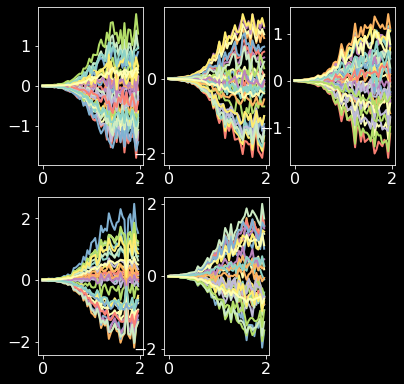

In [6]:
sig_gen = make_signal_generator()
for class_ix in range(N_CLASSES):
    plt.subplot(2, 3, class_ix + 1)
    plt.plot(tvec, sig_gen(class_ix))
plt.show()

In [7]:
N_TRIALS = 10000
BATCH_SIZE = 8

sig_gen = make_signal_generator()
Y = np.random.randint(0, high=N_CLASSES, size=N_TRIALS)
X = np.stack([sig_gen(_) for _ in Y])
dataset = tf.data.Dataset.from_tensor_slices((X, Y)).batch(BATCH_SIZE, drop_remainder=True)
dataset.element_spec

(TensorSpec(shape=(8, 50, 32), dtype=tf.float64, name=None),
 TensorSpec(shape=(8,), dtype=tf.int32, name=None))

### Modify dataset

Using Keras' training requires the dataset to be an x,y tuple, where x is the input and y are the values to which the model output will be compared. The autoencoder tries to reconstruct the input, thus the y values are just a copy of the x values. We do this by mapping a function to the dataset, where the function is a simple lambda that takes in x,y and returns x,x.

However, our model generates 2 outputs (explained later), so Keras expects 2-length tuple in y. So we map our data from x,y --> x,(x, x).

Note, only the last output of the model is compared to the input, the others are used for loss calculations that do not depend on the model outputs. We can save memory by mapping the first two outputs to empty tensors.

In [8]:
ae_dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32),
                                       (tf.zeros(0, dtype=tf.float32), tf.cast(x, tf.float32))))
print(ae_dataset.element_spec)

(TensorSpec(shape=(8, 50, 32), dtype=tf.float32, name=None), (TensorSpec(shape=(0,), dtype=tf.float32, name=None), TensorSpec(shape=(8, 50, 32), dtype=tf.float32, name=None)))


## Variational autoencoder using tensorflow-probability

Tensorflow-probability (tfp) provides a few tools that simplify writing a VAE.

* In the VAE using vanilla tensorflow, the input to our decoder uses a a trick that mimics drawing a sample from a distribution parameterized by our latent vector. With tfp, we can make our latent vector an actual distribution. No trick needed!
* tfp provides the ability to apply KL-regularization directly on our latent distributions.
* We can make the reconstructed signal a distribution, and the reconstruction loss is the negative log-likelihood of the input given the reconstruction distribution.


### Resources

[TF Probability homepage](https://www.tensorflow.org/probability) (within link to [VAE blog post](https://blog.tensorflow.org/2019/03/variational-autoencoders-with.html)).

[TF Probability example of disentangled VAE](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py) from [Li and Mandt, ICML 2018](https://arxiv.org/pdf/1803.02991.pdf).

#### A Note About TFP Distribution Shapes

* Event shape describes the shape of a single draw from the distribution; it may be dependent across dimensions. For scalar distributions, the event shape is `[]`. For a bivariate, it is `[2]`, and for a 5-dimensional MultivariateNormal, the event shape is `[5]`.
* Batch shape describes independent, not identically distributed draws, aka a "batch" of distributions.
* Sample shape describes independent, identically distributed draws of batches from the distribution family.

### Define the latent prior

What distribution do we assume the latent variables should follow? In the case of variational autoencoders we typically assume that the latents are (a) Guassian, (b) have mean=0, and (c) have diagonal covariance. The following demonstrates multiple ways to create such a distribution, with fixed parameters.

#### Prior - Off-diagonal covariance?

I guess that depends on if the latent posterior variables should be regularized against having off-diagonals. If the goal is for the latents to describe an orthonormal space, at least as much as possible without sacrificing model quality, then the prior should not have any off-diagonal covariances. Indeed, I have never seen a prior that was not set to be diagonal. If the posterior is not allowed off-diagonals then definitely do not put off-diagonals in the prior.

#### Prior - Fixed or Learnable?

Do we want to enforce these static priors? Or do we want to allow the priors to update as the model trains? The answer depends primarily on if we think that we have a good prior. There is a small discussion about this in the [tfp regression tutorial](https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html) in Case 3:

> Note that in this example we are training both P(w) (_prior_) and Q(w) (_posterior_). This training corresponds to using Empirical Bayes or Type-II Maximum Likelihood. We used this method so that we wouldn’t need to specify the location of the prior for the slope and intercept parameters, which can be tough to get right if we do not have prior knowledge about the problem. Moreover, if you set the priors very far from their true values, then the posterior may be unduly affected by this choice. A caveat of using Type-II Maximum Likelihood is that you lose some of the regularization benefits over the weights. If you wanted to do a proper Bayesian treatment of uncertainty (if you had some prior knowledge, or a more sophisticated prior), you could use a non-trainable prior (see Appendix B).

The prior is fixed in many of the TFP introductory examples. This is because the intro examples meet conditions under which it doesn't matter if the prior is trainable. [See here](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py#L55-L86) for more info.

----

The next cell, in the last example, implements a learnable multivariate normal distribution.

[`tfp.util.TransformedVariable`](https://www.tensorflow.org/probability/api_docs/python/tfp/util/TransformedVariable): Variable tracking object which applies function upon convert_to_tensor

[`tfp.bijectors.FillScaleTriL`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/FillScaleTriL): Transforms unconstrained vectors to TriL matrices with positive diagonal.


I have also seen this implemented as a [custom class](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py#L185-L315).

Or [as a callable that returns another callable](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb#scrollTo=aAQhyK9Y_lm1&line=4&uniqifier=1) to be passed to `tfpl.DenseVariational`'s `make_prior_fn` argument.

In [9]:
tfb = tfp.bijectors
def make_mvn_prior(ndim, trainable=False, offdiag=False):
    if not trainable:
        if offdiag:
            # With covariances
            # Note: Diag must be > 0, upper triangular must be 0, and lower triangular may be != 0.
            prior = tfd.MultivariateNormalTriL(
                loc=tf.zeros(ndim),
                scale_tril=tf.eye(ndim)
            )
        else:            
            if True:  # kl_exact needs same dist types for prior and latent.
                prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ndim), scale_diag=tf.ones(ndim))
            else:
                prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ndim), scale=1),
                                        reinterpreted_batch_ndims=1)
    else:
        # Note, in TransformedVariable, the initial value should be that AFTER transform
        if offdiag:
            prior = tfd.MultivariateNormalTriL(
                loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                name="prior_loc"),
                scale_tril=tfp.util.TransformedVariable(
                    tf.random.normal([ndim, ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                    tfb.FillScaleTriL(), name="prior_scale")
            )
        else:
            scale_shift = np.log(np.exp(1) - 1).astype(np.float32)
            prior = tfd.MultivariateNormalDiag(
                loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                name="prior_loc"),
                scale_diag=tfp.util.TransformedVariable(
                    tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                    bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(scale_shift)]),
                    name="prior_scale"
                )
            )
    return prior

### Encoder

The input is transformed into some lower dimensional latent variable. In this case we use a `Bidirectional(LSTM)`. This may not be the right layer for you. We use it here because it is similar to what is used in the disentangled_vae example in the tfp source code.

Then the latent variables are used to parameterize a distribution. It's arguable whether the distribution is part of the encoder, the decoder, or something in between, but we will put it in the encoder.

#### Off-diagonal covariance in latent?

In the [tfp example VAE scripts](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/examples), all the latents were `MultivariateNormalDiag`, i.e. no off-diagonal covariances. However, in the [VAE with TFP blog post](https://blog.tensorflow.org/2019/03/variational-autoencoders-with.html), the encoded latents used `MultivariateNormalTriL`, and thus were allowed off-diagonals (though the prior did not). Allowing off-diagonals also increases the number of the parameters in the model which might increase the number of samples of data needed.

#### Mixture of distributions or single distributions?

While this applies to different distribution families as well, we are using Normal distributions. Each independent latent can be modeled as a single Normal or a mixture of Normals. When using a mixture, analytic KL divergence won't work, and more data is required to fit the additional parameters.

I have never used mixture of Gaussians, but the below snippet is a demonstration of how that might work:

```Python
tfd.MixtureSameFamily(
      components_distribution=tfd.MultivariateNormalDiag(
          loc=tf.Variable(mixture_components, latent_size),
          scale_diag=tf.nn.softplus(tf.Variable(mixture_components, latent_size))),
      mixture_distribution=tfd.Categorical(logits=Variable(mixture_components)),
      name="prior")

tfp.layers.MixtureNormal(num_components, event_shape=(LATENT_DIM,))
```

#### Additional transform on covariance

For the Normal distributions, the initialized value for the mean (`loc`) is typically centered on `0.0`, and the value for the std (`scale`) is typically centered on `1.0`. When these values are changing with training (from previous layer or `tf.Variable` in the case of a trainable prior), care should be taken so that the learnable variables are centered around their expected initial values and are of similar magnitude. I believe the training machinery works better under these conditions.

For the `loc` there is nothing to do because it is already centred at 0 and there are no requirements for it to be positive.

For the `scale`, we want the loss to update values that are by default centered on 0, but when the distribution is sampled, the stddev is centered around 1. Also, we have to be careful that the stddev doesn't go negative. Scale can be transformed to meet the requirements by adding a bias to the scale and transforming it through [Softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus). Thus, in the distribution itself, the variable for the scale is added to `np.log(np.exp(1) - 1)` (`=softplus_inverse(1.0) ~ 0.55`), and then softplus transformed to yield values centered on 1 (for inputs centered on 0) before it's used to parameterize the distribution for sampling.

```Python
_loc = tfkl.Dense(LATENT_DIM)(_features)
_scale_diag = tfkl.Dense(LATENT_DIM)(_features)
_scale_diag = _scale_diag + np.log(np.exp(1) - 1)
_scale_diag = tf.math.softplus(_scale_diag) + 1e-5
_static_sample = tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.Independent(
        tfd.Normal(loc=t[0], scale=t[1])
    ),
)([_loc, _scale_diag])
```

In the case of a **trainable prior**, we can initialize the `tf.TransformedVariable` for the scale to be around 1 and use a bijector `tf.nn.softplus(_ + np.log(np.exp(1) - 1)) + 1e-5` before sampling. It's a little confusing that the TransformedVariable should be initialized to its transform value, but the stored initial value is obtained by transforming the initial value through the inverse of the bijector. See the `make_mvn_prior` function definition for an example.

#### Number of samples from distributions?

For any given pass through the model, the distributions can be sampled multiples times. For example, on the output distribution, we can get N_SAMPLES different reconstructions, but then we must calculate the error for each sample (e.g., using 'mse') and take the average error, or we can calculate the probability for each sample and take the average probability: `tf.reduce_logsumexp(elbo) - tf.math.log(n_samples)`.

```Python
_static_sample = tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.Independent(tfd.Normal(loc=t[0], scale=t[1])),
    convert_to_tensor_fn=lambda s: s.sample(N_SAMPLES)
)([_loc, _scale_diag])
```

In [10]:
def make_mvn_dist_fn(_x_, ndim, offdiag=False):
    _loc = tfkl.Dense(ndim)(_x_)
    if offdiag:
        _scale = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(ndim) - ndim)(_x_)
        _scale = tfp.bijectors.FillScaleTriL()(_scale)  # softplus(x+0.5413) + 1e-5 --> lower tri mat
        make_dist_fn = lambda t: tfd.MultivariateNormalTriL(loc=t[0], scale_tril=t[1])
    else:
        _scale = tfkl.Dense(ndim)(_x_)
        _scale = tf.math.softplus(_scale + np.log(np.exp(1) - 1)) + 1e-5
        if True:  # Match type with prior
            make_dist_fn = lambda t: tfd.MultivariateNormalDiag(loc=t[0], scale_diag=t[1])
        else:
            make_dist_fn = lambda t: tfd.Independent(tfd.Normal(loc=t[0], scale=t[1]))
    return make_dist_fn, [_loc, _scale]

#### KL Divergence

The latent posterior distribution is regularized to resemble the prior distribution by penalizing the KL divergence between the posterior and the prior. There are several ways to do this.

1. Add KL divergence to the model or a custom loss function
    1. Calculate loss:
        1. Using analytic KL divergence (not for mixture models):
            `kl_loss = tfd.kl_divergence(posterior, prior)`
        2. Manual KL divergence:
            `kl_loss = posterior.log_prob(sample) - prior.log_prob(sample)`
    2. It may be necessary to `tf.reduce_mean(kl_loss)` to match shape of other losses, depending on sampling.
    3. Add to other losses, like -log_likelihood.
2. Using [`tfpl.KLDivergenceAddLoss(prior)`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/KLDivergenceAddLoss)
3. Add KL regularizer directly to latent distribution.
    ```Python
    posterior = tfpl.SomeLayer(...,
                               activity_regularizer=tfpl.KLDivergenceRegularizer(
                                   prior, weight=KL_WEIGHT)
                              )
    ```
    
Adding the loss directly to the layer is the easiest way because then we don't need to keep a handle for the posterior distribution itself.
    
##### Weighting by number of samples

If we allow the KL divergence loss to be weighted too heavily then the model will prioritize matching the prior more than solving the output objective. This is especially problematic when we do not have a learnable prior. I looked to available examples to see what the conventions were. But this left me more confused.

* In Regression blog post and [accompanying google colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb): `rv_y.variational_loss(y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])`
* In vae blog post: `activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=1.0))`
* In vae example script:
    * `weighted_elbo = tf.reduce_logsumexp(elbo) - tf.math.log(n_samples)`
    * But the above is not used. If it were: `loss = -tf.reduce_mean(weighted_elbo)`
* In `kernel_divergence_fn` kwarg for `tfpl.DenseFlipout` in [logistic_regression example](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/logistic_regression.py#L177-L190): `kernel_divergence_fn=lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(num_samples, dtype=tf.float32)`
* In API docs for `tfpl.KLDivergenceRegularizer` or `tfpl.KLDivergenceAddLoss`, example code sets `weight=num_train_samples`. Isn't this the opposite of the other examples?
* In disentangled vae example: Not done!
* [In LFADS](https://github.com/tensorflow/models/blob/master/research/lfads/lfads.py#L829-L830): "normalized only by batch size, not by dimension or by time steps" - implicit in `tf.reduce_mean()`.

In my confusion I [posted a question](https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/ZZKblgnDnUE) to the TensorFlow Probability mailing list. Someone answered pointing me to other similar conversations. As best as I can understand, it seems that the **conventional scaling to apply to the KL divergence term is (batch_size / number_of_samples)**.

##### KL annealing

Sometimes units can become inactive and stay inactive if they become trapped in a local minimum when the KL distance is near 0. Therefore, it is often beneficial to drastically deprioritize the prior at training outset then gradually increase the KL weight as training progresses. This is well described in section 2.3 of the [Ladder VAE paper](https://arxiv.org/abs/1602.02282).

We can alo make the beta term cyclical which provides other benefits [as described here](https://arxiv.org/abs/1903.10145).

For this to work with the Keras training syntax, we need the weight to be a non-trainable variable that changes during a callback. You can find an example implementation [here](https://gist.github.com/pnb/0b66a49e40f18b9c77f2ade7cc5b039)

In [48]:
LATENT_DIM = 3

vae_model = None
encoder_model = None
K.clear_session()
K.set_floatx('float32')
tf.random.set_seed(42)

In [49]:
kl_beta = K.variable(value=0.0)
kl_beta._trainable = False  # It isn't trained. We set it explicitly with the callback.

def kl_beta_update(epoch_ix, N_epochs, M_cycles=4, R_increasing=0.5):
    T = N_epochs // M_cycles
    tau = (epoch_ix % T) / T
    new_beta_value = tf.minimum(1.0, tau/R_increasing)
    # new_beta_value = new_beta_value * BATCH_SIZE  #  / N_TRIALS
    K.set_value(kl_beta, new_beta_value)
    
# Add the following to the list of model.fit callbacks.
# (we may overwrite this later after we've defined our N_EPOCHS constant)
kl_beta_cb = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, log: kl_beta_update(epoch, N_epochs=30))

In [50]:
LATENT_OFFDIAG = True  # Set to False to restrict latents to being independent (diagonal covariance)
N_HIDDEN = 16
NUM_SAMPLES = 1

# Create the prior which will be used to calculate KL-divergence of latent dists:
prior = make_mvn_prior(LATENT_DIM, trainable=False, offdiag=LATENT_OFFDIAG)

_input = tfkl.Input(shape=(n_timesteps, N_SENSORS))
_x = tfkl.Bidirectional(tfkl.LSTM(N_HIDDEN), merge_mode="sum")(_input)
make_dist_fn, params = make_mvn_dist_fn(_x, LATENT_DIM, offdiag=LATENT_OFFDIAG)
q_z = tfpl.DistributionLambda(
    name="q_z",
    make_distribution_fn=make_dist_fn,
    convert_to_tensor_fn=lambda s: s.sample(NUM_SAMPLES),
    activity_regularizer=tfpl.KLDivergenceRegularizer(
        prior, use_exact_kl=True, weight=kl_beta)
)(params)

#encoder_model = tf.keras.Model(inputs=_input, outputs=q_z)
#encoder_model.summary()
#tf.keras.utils.plot_model(encoder_model)

### Decoder

#### Which distribution?

The **output** distribution should, as much as possible, make sense for the type of data being generated. Some examples:

* binarized pixels -- independent bernoulli
* spike counts -- independent Poisson
* Any aggregate of many small-scale processes -- Normal (Gaussian)

Biological signals _sometimes_ follow Gaussian distributions. When they don't, it's usually a good idea to transform them so that they do, because many data science tools work best with Gaussian data.

For similar reasons, it's quite common to scale the data so that they have a standard deviation of 1.0.

What about covariances? This should be considered separately for every dataset. For the present data, the signals were created by mixing latents, so it is expected that signals with contributions from the same latents will covary, and therefore we should generate outputs with covariances. But in practice it doesn't matter here and it slows down training so we'll go with diagonal-only.

In [51]:
OUTPUT_OFFDIAG = False

# tfkl.RepeatVector doesn't work on distributions, so we do it manually by broadcast-add to zeros.
_y = q_z[..., tf.newaxis, :] + tf.zeros([n_timesteps, 1])
_y = tf.reshape(_y, [-1, n_timesteps, LATENT_DIM])  # RNN requires ndim=3: Collapse samp + batch dims
_y = tfkl.LSTM(N_HIDDEN, return_sequences=True)(_y)
_y = tf.reshape(_y, [NUM_SAMPLES, -1, n_timesteps, N_HIDDEN])  # Restore sample dim

# GRU output parameterizes distribution
make_dist_fn, params = make_mvn_dist_fn(_y, N_SENSORS, offdiag=OUTPUT_OFFDIAG)

p_full = tfpl.DistributionLambda(
    make_distribution_fn=make_dist_fn,
    name="p_full"
    # No KL regularizer on output distribution. Will calculate p(recon|inputs) as model loss.
)(params)

### Model

To the model's `outputs=` kwarg we pass a tuple of both the latent distribution and the output distribution. We do this for one reason only: to monitor the KL divergence loss during training. If you recall, the dataset Y was mapped to (zeros, x) tuple to give us 2 outputs. The compiled model has 2 `loss` functions: the first calculates the KL divergence of the latent from the prior, and the second calculates the -log-likelihood of the data on the output distribution. The first loss has a weight of 0.0 and is thus not used in updating the model variables. It is not needed because the KL-divergence for updating the model variables is calculated in the activity_regularizer for the prior distribution in the encoder model. Yet, Keras' `model.fit` will still print out the KL loss (here called "q_z_loss").

If we didn't want to monitor the KL-loss, we could simplify things a little by removing the first output from the model, changing the dataset from outputting (zeros, x) to only output x, removing the first loss-fn from the `loss` kwarg in model.compile, and getting rid of the `loss_weights` kwarg.

In [52]:
vae_model = tf.keras.Model(inputs=_input, outputs=[q_z, p_full])
vae_model.summary()
# tf.keras.utils.plot_model(vae_model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 32)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 16)           6272        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6)            102         bidirectional[0][0]              
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           dense_1[0][0]                    
______________________________________________________________________________________________

### Model Fitting

#### Manual Training - Can skip to Keras training in next cell

In [53]:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py#L1126
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#train_the_model
@tf.function
def grad(model, inputs):
    with tf.GradientTape() as tape:
        q_z, p_full = model(inputs, training=True)
        
        # Reconstruction log-likelihood: p(output|input)
        recon_post_log_prob = p_full.log_prob(inputs)
        recon_post_log_prob = tf.reduce_mean(recon_post_log_prob)
        
        # KL Divergence - analytical
        # manual_kl = tfd.kl_divergence(q_z, prior)
        # manual_kl = kl_beta * BATCH_SIZE * tf.reduce_mean(manual_kl)
        # manual_kl no longer needed because KL loss in regularizer.
        # (but why is it in there twice?)
        
        loss = -recon_post_log_prob + model.losses[0]
        if False:  # Only works when no @tf.function
            print(f"recon_post_log_prob: {recon_post_log_prob}")
            print(f"manual kl: {kl_weight} * {manual_kl}")
            # calc_kl = encoder_model.get_layer(name="latents").losses
            # print(f"model.losses: {model.losses}")
            print("\n")
            
    grads = tape.gradient(loss, model.trainable_variables)
    return loss, grads, manual_kl

if False:
    # Some debug code
    epoch_ix = 10
    kl_beta_update(epoch_ix, N_EPOCHS)
    x_in = list(ae_dataset.as_numpy_iterator())[0][0]
    loss, grads, _others = grad(vae_model, x_in)
    print(loss, _others)
elif False:
    for epoch_ix in range(N_EPOCHS):
        kl_beta_warmup(epoch_ix)
        for step_ix, (x_in, x_pred) in enumerate(ae_dataset):
            loss, grads, _kl = grad(vae_model, x_in)
            optim.apply_gradients(zip(grads, vae_model.trainable_variables))
            if (step_ix % 200) == 0:
                print('.')
        print(f"Epoch {epoch_ix}/{N_EPOCHS}:\tloss={loss:.3f};"
              f"\tkl={kl_beta.numpy():.3f} * {_kl:.3f}")

#### Keras Training

In [54]:
N_EPOCHS = 30
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae_model.compile(optimizer=optim,
                  loss=[lambda x_true, enc_out: tfd.kl_divergence(enc_out, prior),
                        lambda x_true, model_out: -model_out.log_prob(x_true)],
                  loss_weights=[0.0, 1.0])
history = vae_model.fit(ae_dataset,
                        epochs=N_EPOCHS,
                        callbacks=[kl_beta_cb],
                        verbose=1)

Train for 1250 steps
Epoch 1/30
1250/1250 [==============================] - 16s 13ms/step - loss: -8.5171 - q_z_loss: 20.5027 - p_full_loss: -8.5172
Epoch 2/30
1250/1250 [==============================] - 13s 10ms/step - loss: 7.7842 - q_z_loss: 4.1175 - p_full_loss: -11.0389
Epoch 3/30
1250/1250 [==============================] - 13s 10ms/step - loss: 0.5828 - q_z_loss: 2.1508 - p_full_loss: -19.0814
Epoch 4/30
1250/1250 [==============================] - 13s 10ms/step - loss: -0.5595 - q_z_loss: 1.3557 - p_full_loss: -19.1525
Epoch 5/30
1250/1250 [==============================] - 13s 10ms/step - loss: -3.9823 - q_z_loss: 0.7509 - p_full_loss: -15.9960
Epoch 6/30
1250/1250 [==============================] - 13s 10ms/step - loss: -6.7917 - q_z_loss: 0.5587 - p_full_loss: -15.7303
Epoch 7/30
1250/1250 [==============================] - 13s 10ms/step - loss: -8.0314 - q_z_loss: 0.5710 - p_full_loss: -17.1676
Epoch 8/30
1250/1250 [==============================] - 13s 10ms/step - loss: 

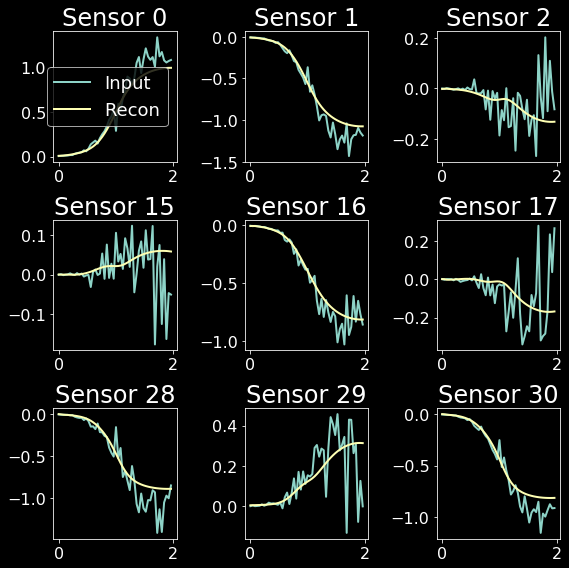

In [55]:
plt.figure(figsize=(8, 8))

trial_ix = 10
test_X = X[trial_ix, :, :].astype(np.float32)[None, ...]
recon_X = np.mean(vae_model(test_X)[1].mean().numpy(), axis=0)
    
for chan_ix, chan_idx in enumerate([0, 1, 2, 15, 16, 17, 28, 29, 30]):
    plt.subplot(3, 3, chan_ix + 1)
    plt.plot(tvec, test_X[0, :, chan_idx], label="Input")
    plt.plot(tvec, recon_X[0, :, chan_idx], label="Recon")
    plt.title(f"Sensor {chan_idx}")
    if chan_ix == 0:
        plt.legend()

plt.tight_layout()
plt.show()

### Visualize Latents

Start by visualizing the per-class latent distributions for each pair of latent variables.


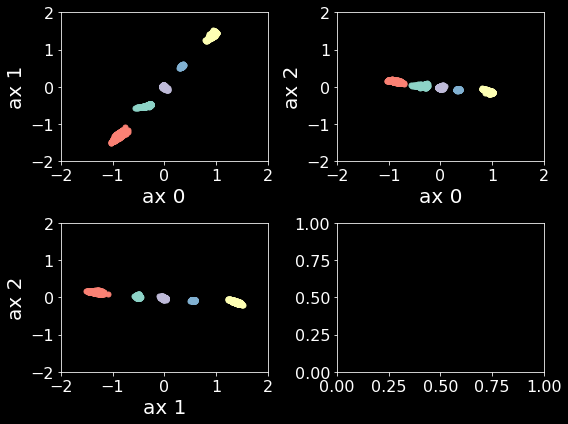

In [60]:
# Scatter plot per class
plot_range = [-2.0, 2.0]
fig = plt.figure(figsize=[8, 6], tight_layout=True)
axes = fig.subplots(2, 2)

for class_id in np.unique(Y):
    b_class = Y == class_id
    lat_dist = vae_model(X[b_class].astype(np.float32))[0]
    lat_dist = lat_dist.mean().numpy()
    for pair_ix, dim_pair in enumerate([[0, 1], [0, 2], [1, 2]]):
        row_ix = pair_ix // 2
        col_ix = pair_ix % 2
        axes[row_ix, col_ix].scatter(lat_dist[:, dim_pair[0]], lat_dist[:, dim_pair[1]])
        axes[row_ix, col_ix].set_xlim(plot_range)
        axes[row_ix, col_ix].set_ylim(plot_range)
        axes[row_ix, col_ix].set_xlabel(f"ax {dim_pair[0]}")
        axes[row_ix, col_ix].set_ylabel(f"ax {dim_pair[1]}")

Visualize reconstructions as a function of moving initial factor in latent space.

In [61]:
gen_model = tf.keras.Sequential([
    tfkl.Input(shape=(LATENT_DIM,)),
    tfkl.RepeatVector(n_timesteps),
    tfkl.LSTM(N_HIDDEN, return_sequences=True),
    tfkl.Dense(N_SENSORS)
])
gen_model.layers[-2].set_weights(vae_model.get_layer(name='lstm_1').get_weights())
gen_model.layers[-1].set_weights(vae_model.get_layer(name='dense_2').get_weights())
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 50, 3)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 16)            1280      
_________________________________________________________________
dense_4 (Dense)              (None, 50, 32)            544       
Total params: 1,824
Trainable params: 1,824
Non-trainable params: 0
_________________________________________________________________


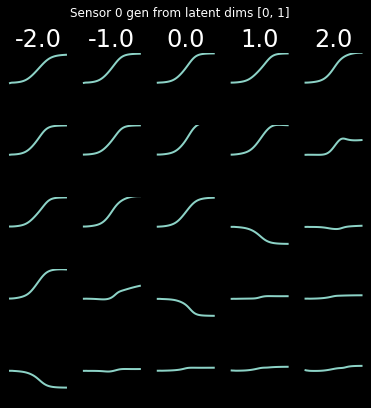

In [62]:
N_GRID = 5
dim_idx = [0, 1]
sensor_ix = 0
samp_amp = 2.0

d0 = np.linspace(-samp_amp, samp_amp, N_GRID)
d1 = np.linspace(-samp_amp, samp_amp, N_GRID)
v0, v1 = np.meshgrid(d0, d1)

fig = plt.figure()
fig.suptitle(f"Sensor {sensor_ix} gen from latent dims {dim_idx}")
for pl_ix in range(N_GRID**2):
    latent = np.zeros((1, LATENT_DIM), dtype=np.float32)
    latent[0, dim_idx[0]] = v0.flatten()[pl_ix]
    latent[0, dim_idx[1]] = v1.flatten()[pl_ix]
    gen_data = gen_model(latent).numpy()[0]

    plt.subplot(N_GRID, N_GRID, pl_ix + 1)
    plt.plot(gen_data[:, sensor_ix])
    plt.axis('off')
    plt.ylim([-1, 1])
    
    #if (pl_ix + 1) % N_GRID == 1:
    #    plt.ylabel(f"{latent[0, dim_idx[1]]:.1f}")
    if pl_ix < N_GRID:
        plt.title(f"{latent[0, dim_idx[0]]:.1f}")


Visualize latent distributions. I need a cleverer way of overlaying multiple distributions than just adding them up.

In [63]:
mus = []
sigmas = []
for class_id in np.unique(Y):
    b_class = Y == class_id
    tmp = np.mean(X[b_class], axis=0, keepdims=True)
    lat_dist = vae_model(tmp.astype(np.float32))[0]
    mus.append(lat_dist.mean().numpy())
    sigma = np.eye(4)
    np.fill_diagonal(sigma, lat_dist.variance())
    sigmas.append(sigma)
mus = np.squeeze(np.array(mus))
sigmas = np.squeeze(np.array(sigmas))

plot_range = [-2, 2]
grid_steps = 20
xx, yy = np.mgrid[plot_range[0]:plot_range[1]:(1/grid_steps),
                  plot_range[0]:plot_range[1]:(1/grid_steps)]
positions = np.dstack((xx, yy))

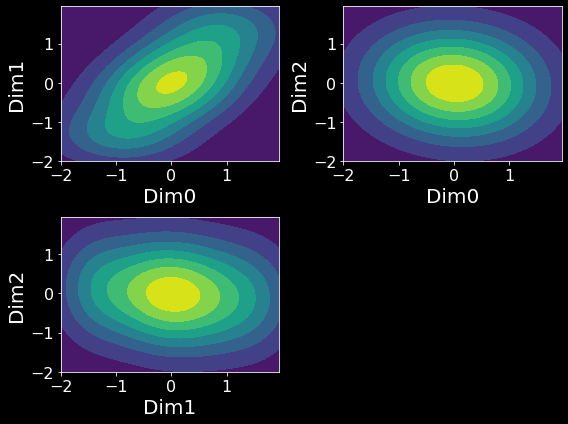

In [64]:
from scipy.stats import multivariate_normal

def bivariate_contour(class_id=0, dim0=0, dim1=1):
    test_mus = [mus[class_id][dim0], mus[class_id][dim1]]
    test_sigmas = [[sigmas[class_id][dim0, dim0], 0], [0, sigmas[class_id][dim1, dim1]]]
    rv = multivariate_normal(test_mus, test_sigmas)
    return rv.pdf(positions)

fig = plt.figure(figsize=[8, 6])
for pair_ix, dim_pair in enumerate([[0, 1], [0, 2], [1, 2]]):
    ax = fig.add_subplot(2, 2, pair_ix + 1)
    zzs = np.zeros((positions.shape[:-1]))
    for class_id in range(5):
        dist = bivariate_contour(class_id=class_id, dim0=dim_pair[0], dim1=dim_pair[1])
        zzs += dist / np.max(dist)
    ax.contourf(xx, yy, zzs)
    ax.set_xlabel(f"Dim{dim_pair[0]}")
    ax.set_ylabel(f"Dim{dim_pair[1]}")
plt.tight_layout()